In [10]:
%load_ext autoreload
%autoreload 2

from model import LitModel
from data import LitDataModule
import torch
from torch.utils.data import DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import tqdm
import numpy as np

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
CHECKPOINT = '/n/home03/creissel/Seismic/runs/test/lightning_logs/ovklkhna/checkpoints/epoch=30-step=1705.ckpt'

In [12]:
model = LitModel.load_from_checkpoint(CHECKPOINT)
model = model.to(device)
model = model.eval()
dataset = LitDataModule.load_from_checkpoint(CHECKPOINT)

In [13]:
pred = []
true = []
with torch.no_grad():
    for inputs, targets in dataset.test_dataloader():
        true.append(targets)
        inputs = inputs.to(device)
        pred.append(model(inputs).detach().cpu().numpy())

In [14]:
pred = np.concatenate(pred, axis=0)
pred = pred[:,:,0]

true = np.concatenate(true, axis=0)
true = true[:,:,0]

In [15]:
noverlap = int((60.0 - 1.0) * 4)

def overlap_add(data, noverlap, window, verbose=True):
    # Get dimension
    N, nperseg = data.shape
    stride = nperseg - noverlap

    # Get window function
    if isinstance(window, str):
        window = _parse_window(nperseg, noverlap, window)

    # Concatenate timeseries
    nsamp = int((N - 1) * stride + nperseg)
    new = np.zeros(nsamp)
    for i in range(N):
        new[i * stride: i * stride + nperseg] += data[i] * window
    return new

import scipy.signal as sig
def _parse_window(nperseg, noverlap, window='boxcar'):
    """ Get window function """
    if window == 'rect' or window =='rectangular':
        window = 'boxcar'
    if window == 'hanning':
        window = 'hann'
    window_fn = sig.get_window(window, nperseg)
    if window != 'boxcar':
        return window_fn * (nperseg - noverlap) / nperseg * 2
    else:
        return window_fn * (nperseg - noverlap) / nperseg


In [16]:
pred = overlap_add(pred, noverlap, 'hanning')
true = overlap_add(true, noverlap, 'hanning')

In [17]:
# remove first and last kernel
true = true[60*4:-60*4]
pred = pred[60*4:-60*4]

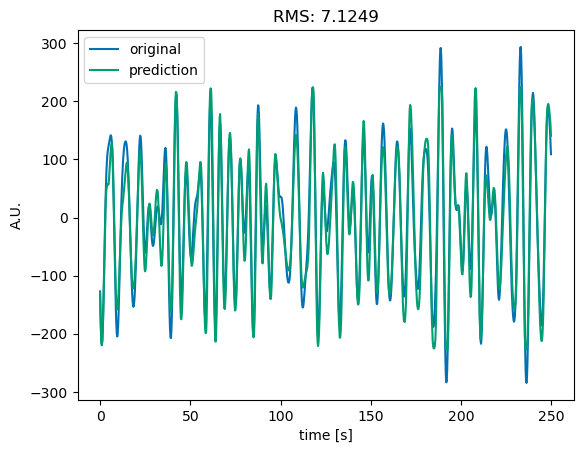

In [18]:
plt.plot(np.arange(0,1000/4.,1/4.), true[:1000], label='original', color='#0072B2')
plt.plot(np.arange(0,1000/4.,1/4.), pred[:1000], label='prediction', color='#009E73')
plt.title('RMS: %.4f' %(np.sqrt(np.mean((pred-true))**2)))
plt.xlabel('time [s]')
plt.ylabel('A.U.')
plt.legend()